In [1]:
from google.colab import drive      
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
!nvidia-smi

Tue Nov  3 14:20:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installations

In [2]:
%%shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 11076, done.
remote: Total 11076 (delta 0), reused 0 (delta 0), pack-reused 11076
Receiving objects: 100% (11076/11076), 12.59 MiB | 21.88 MiB/s, done.
Resolving deltas: 100% (7723/7723), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import cv2
import matplotlib.pyplot as plt
import json
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
from PIL import Image, ImageDraw

import torchvision
from torch.utils.data import Dataset, DataLoader

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor,FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.rpn import RPNHead
from torchvision.datasets import CocoDetection

import torch.optim as optim
from torchvision import transforms


import torch
from torch.utils.data import random_split

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import pycocotools
import utils
import transforms as T

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device: ', device)

PATH = '/content/gdrive/My Drive/Training_afeka_object_detection/images'


device:  cuda


# <strong> Part 1:</strong> Getting the face mask data and  preprocceening it!

In order to build an object detection model, data is required. without it the model wont learn to detect anything. In this notebook, we build a neural network for detecting face masks. To be precise, we trained a model for detect whether a person is wearing a mask as required. 
Apart from the images we didn't get any information about the locations and size of the masks we would like to identify, we chose to use a great and simple **COCO Annotator** tagging tool which allows you to tag the object (masks) and get a json file with the desired label details in coco format.
Practical knowledge of this tool will allow us in the future to train models to detect any object we want.



In [ ]:
with open('/content/gdrive/My Drive/finished_total.json') as json_data: # Read annotations file
    data = json.load(json_data)

images = []
for dic in data['images']:
    images.append((dic['file_name'], dic['id'], dic['height'], dic['width']))

We manually extracted for each image its annotations from the file, at the end we created a data frame so that we could continue the processing more easily and draw conclusions about the form of the training.

in the json file for each image has a list with all of its bbox. In the data frame we separated so that each BBOX would appear in a separate row

In [ ]:
def get_dic_format(index, image_id, path, height, width, x_min, y_min, x_max, y_max, w, h, area, label):
    return {
                            'index': index,
                            'image_id': image_id,
                            'path': path,
                            'height': height,
                            'width': width,
                            'x_min': x_min,
                            'y_min': y_min,
                            'x_max': x_max,
                            'y_max': y_max,
                            'w': w,
                            'h': h,
                            'area': area,
                            'label': label               
                        }
path = PATH + '/*'
train_paths = glob(path)
new_data = []
for img in images: # Run over the images from json file
    for p in train_paths:
        name = p.split('/')[-1]
        if img[0] == name: #Finding an image and detailing it by comparing images names
            none_bbox = False
            for dic in data['annotations']:
                if dic['image_id'] == img[1]:
                    box = dic['bbox']
                    y = int(box[0])
                    x = int(box[1])
                    h = int(box[2])
                    w = int(box[3])
                    if h*w != 0:
                        none_bbox = True
                        new_data.append(get_dic_format(img[1], img[0], 
                                                       p, img[2], img[3], 
                                                       x, y, (x+w), (y+h), 
                                                       w, h, dic['area'], 1))
            if not none_bbox:
                new_data.append(get_dic_format(img[1], img[0], 
                                               p, img[2], img[3], 
                                               0, 0, 0, 0, 0, 0, 0, 0))



df = pd.DataFrame.from_dict(new_data)
display(df)


index            image_id  ...  area  label
0       56  maksssksksss77.png  ...  1344      1
1       56  maksssksksss77.png  ...   986      1
2       56  maksssksksss77.png  ...   286      1
3       57  maksssksksss49.png  ...   240      1
4       57  maksssksksss49.png  ...   192      1
..     ...                 ...  ...   ...    ...
599    209  maksssksksss48.png  ...     0      0
600    210  maksssksksss51.png  ...     0      0
601    211  maksssksksss68.png  ...     0      0
602    212  maksssksksss72.png  ...     0      0
603    213  maksssksksss95.png  ...     0      0

[604 rows x 13 columns]

[https://media1.tenor.com/images/42983a95657f874f62cfc1f1152da484/tenor.gif]
[link text](https://media1.tenor.com/images/42983a95657f874f62cfc1f1152da484/tenor.gif)



```
from IPython.display import Image
Image(url='https://media1.tenor.com/images/42983a95657f874f62cfc1f1152da484/tenor.gif')
# This is formatted as code
```



In [ ]:
# Helper functions for statics part

def count_boxes(df):
    images_list = df['image_id'].unique()
    with_mask = []
    without_mast = []
    count_boxes = 0
    total = 0
    for name in images_list:
        mini_df = df[df['image_id'] == name]
        if mini_df['label'].values[0] == 1:
            count_boxes+=1
            with_mask.append(*mini_df['path'].unique())
            total += len(mini_df)
        else:
            without_mast.append(*mini_df['path'].unique())

    return count_boxes, with_mask, without_mast, total/count_boxes

def avargae_height(df):
    return df['height'].mean()

def avargae_width(df):
    return df['width'].mean()

def avargae_area(df):
    return df['area'].mean()

from PIL import Image, ImageDraw
def add_bbox(path, size=(600, 600)):
    image = Image.open(path)
    draw = ImageDraw.Draw(image)
    for anno in df[df['path'] == path][['x_min','y_min', 'x_max', 'y_max']].values:
        draw.rectangle([(anno[1], anno[0]), (anno[3], anno[2])], outline ="blue", width =3)
    image = image.resize(size)
    return(image)

def plot_images(paths, title):
    imgs = [add_bbox(path) for path in np.random.choice(paths, 4, replace=False)]
    plt.figure(figsize=(20, 5))
    plt.suptitle(title, fontsize=20)
    for i, img in enumerate(imgs):
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


In [ ]:
from IPython.display import Image
Image(url='https://media1.tenor.com/images/42983a95657f874f62cfc1f1152da484/tenor.gif?itemid=8718500')

Total number of images 200
Total number of images with face mask 187
Total number of images without face mask 13
Avarge image height 265.9933774834437
Avarge image width 384.2251655629139
Avarge masks in image 3.160427807486631


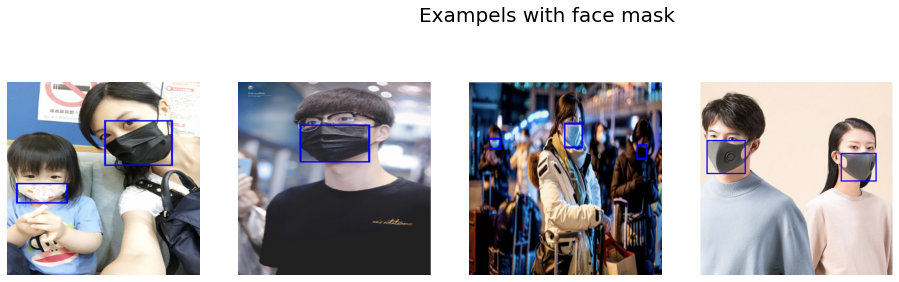

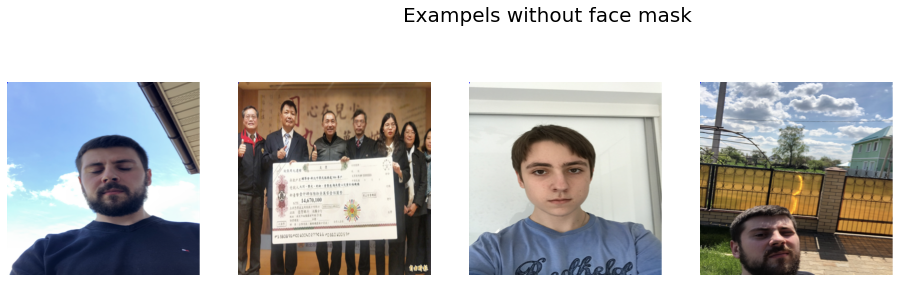

In [ ]:
count_boxes, with_mask, without_mask, avg_boxes = count_boxes(df)
total_lenght = len(df['image_id'].unique())
print(f'Total number of images {total_lenght}')
print(f'Total number of images with face mask {count_boxes}')
print(f'Total number of images without face mask {total_lenght - count_boxes}')
print(f'Avarge image height {avargae_height(df)}')
print(f'Avarge image width {avargae_width(df)}')
print(f'Avarge masks in image {avg_boxes}')

plot_images(with_mask, 'Exampels with face mask')
plot_images(without_mask, 'Exampels without face mask')

After examining the images we saw that on average there are between 3 and 4 face masks in each image. In addition we noticed that in most of the pictures the amount of people who don't wear face mask is larger, we decided not to define this as  "no mask" labels and add this case to background labels.
By taking this assumption we ignore the images without any face mask in it.

In [ ]:
#remove negative examples 
df = df[df['label']!=0]
display(df)

index             image_id  ...  area  label
0       56   maksssksksss77.png  ...  1344      1
1       56   maksssksksss77.png  ...   986      1
2       56   maksssksksss77.png  ...   286      1
3       57   maksssksksss49.png  ...   240      1
4       57   maksssksksss49.png  ...   192      1
..     ...                  ...  ...   ...    ...
586     46   maksssksksss11.png  ...   300      1
587     47  maksssksksss107.png  ...  6970      1
588     48  maksssksksss129.png  ...   504      1
589     49  maksssksksss141.png  ...  1170      1
590     49  maksssksksss141.png  ...  1892      1

[591 rows x 13 columns]

# Costume face mask dataset

In [4]:
def get_annotations(annotations, device='cuda'):
  ''' convert a single annotation to a none coco format '''

  label =  {
      'boxes': torch.tensor([to_rcnnformat(a['bbox']) for a in annotations]).to(device), 
      'labels': torch.tensor([1 for a in annotations]).to(device), 
      'image_id': torch.tensor(annotations[0]['image_id']).to(device), 
      'area': torch.tensor([a['area'] for a in annotations]).to(device),
      'iscrowd': torch.tensor([0 for a in annotations]).to(device)
      }

  return label

def to_rcnnformat(bbox):
  ''' convert a coco bounding box to a none coco format '''
  return [bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]]

class FaceMaskDataset(Dataset):
    """ Face Mask dataset """

    def __init__(self, data, root="", transform=None, cocomode=True):
        """
        Args:
            data (dict) json data
            root (string): location of images
            transform (callable, optional): Optional transform to be applied
                on a sample.
            cocomode (bool): whether use coco data formate
        """

        self.images = data['images']
        self.labels = {img['id']:[d for d in data['annotations'] if d['image_id'] == img['id']] for img in self.images}
        self.root = root
        self.imagetotensor = transforms.Compose([transforms.ToTensor()])
        self.transform = transform
        self.cocomode = cocomode
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        im = Image.open(self.root + '/' + self.images[idx]['file_name']).convert('RGB')
        label_idx = self.images[idx]['id']
        label = self.labels[label_idx]

        if not self.cocomode:
          im = self.imagetotensor(im).to(self.device)
          label = get_annotations(label, self.device)

        if self.transform:
            im = self.transform(im)

        return im, label

# Helper functions for initializing the model

In [5]:
def load_resnet(backbone_model, num_classes=2): #backcone_model = ['resnet50', 'resnet101', 'resnet152']
  
    # create an anchor_generator for the FPN
    # which by default has 5 outputs
    anchor_generator = AnchorGenerator(
        sizes=tuple([(32, 64, 128, 256) for _ in range(5)]),
        aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)]))
    
    pretrained_backbone=True
    backbone = resnet_fpn_backbone(backbone_model, pretrained_backbone)
    fasterrcnn = FasterRCNN(backbone, num_classes,
                    rpn_anchor_generator=anchor_generator,
                    rpn_head=RPNHead(256, anchor_generator.num_anchors_per_location()[0]))
    in_features = fasterrcnn.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes = num_classes)
    return fasterrcnn

def get_model(architecture:str, num_classes=2):
    anchor_generator = AnchorGenerator(
                        sizes=tuple([(32, 64, 128, 256) for _ in range(5)]),
                        aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)]))
    if architecture == 'resnet50':
        return load_resnet('resnet50', num_classes)
    if architecture == 'resnet101':
        return load_resnet('resnet101', num_classes)
    if architecture == 'resnet152':
        return load_resnet('resnet152', num_classes)

    if architecture == 'mobilenet':
        backbone = torchvision.models.mobilenet_v2(pretrained=True).features
        backbone.out_channels = 1280
        
    if architecture == 'squeezenet':
        backbone = torchvision.models.squeezenet1_0(pretrained=True).features
        backbone.out_channels = 512

    fasterrcnn = FasterRCNN(backbone, num_classes,
                        rpn_anchor_generator=anchor_generator,
                        rpn_head=RPNHead(backbone.out_channels, anchor_generator.num_anchors_per_location()[0]))
    in_features = fasterrcnn.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes = num_classes)
    return fasterrcnn
        

# **Dataset and Dataloaders**

In [6]:
with open('/content/gdrive/My Drive/all_without_inannotated.json') as json_data: # Read annotations file
    data = json.load(json_data)

def collate_fn(batch):
    return tuple(zip(*batch))

mmasks_dataset = FaceMaskDataset(data, PATH, cocomode=False)

train_dataset, val_dataset, test_dataset = random_split(mmasks_dataset,  
                                                        [150, 27, 10])
                                            
trian_data_loader = DataLoader(train_dataset, batch_size=4, 
                               shuffle=True, collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=1, 
                              shuffle=False, collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=1, 
                             shuffle=False, collate_fn=collate_fn)


In [ ]:
!pip install tensorboard==2.3.0
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()


# Helper functions for training part

In [8]:
def train(model, optimizer, data_loader, device, epoch, print_freq):
    '''We ran the Vision train_one_epoch function
     so that the function returns the training results '''

    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    return metric_logger

def evaluate_loss(data_loader):
    ''' The function calculates the loss error for a validation set '''
    model.train()
    with torch.no_grad():
        losses_graph = []
        for images, targets in tqdm(data_loader):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)            
            losses = sum(loss for loss in loss_dict.values())

            losses_graph.append(float(losses.detach().cpu()))
        loss = sum(losses_graph)/len(losses_graph)
        return loss


# **Precision & recall**

* **Precision:** measures how accurate is your predictions.
* **Recall:** measures how good you find all the positives.

# **COCO mAP**
Latest research papers tend to give results for the COCO dataset only. In COCO mAP, a 101-point interpolated AP definition is used in the calculation. For COCO, AP is the average over multiple IoU (the minimum IoU to consider a positive match). AP@[.5:.95] corresponds to the average AP for IoU from 0.5 to 0.95 with a step size of 0.05. For the COCO competition, AP is the average over 10 IoU levels on 80 categories (AP@[.50:.05:.95]: start from 0.5 to 0.95 with a step size of 0.05). The following are some other metrics collected for the COCO dataset.


![alt text](https://miro.medium.com/max/1050/1*_IkyrFHlqt_xCovk7l0rQQ.png)


In [9]:
from tqdm import tqdm_notebook as tqdm
from engine import *
def run ():
    '''Conduct a complete training for one model.'''
    
    model_metrics = {'train':
                        {'loss': [],
                        'average precision': [],
                        'average recall': []},
                    'validition':
                        {'loss': [],
                        'average precision': [],
                        'average recall': []}}

    for epoch in tqdm(range(num_epochs)):
        # train for one epoch, printing every 10 iterations
        stats = train(model, optimizer, trian_data_loader, device, epoch, print_freq=10)
        model_metrics['train']['loss'].append(stats.meters['loss'].value)
        eval_metrics = evaluate(model, trian_data_loader, device=device)
        # add to graphs plotting section
        model_metrics['train']['average precision'].append(
                                                            eval_metrics.coco_eval['bbox'].stats[0])
        model_metrics['train']['average recall'].append(
                                                            eval_metrics.coco_eval['bbox'].stats[-4])
        # add to tensorboard
        writer.add_scalar("Loss/ Train", stats.meters['loss'].value, epoch)
        writer.add_scalar("Loss/loss_classifier/ Train", stats.meters['loss_classifier'].value, epoch)
        writer.add_scalar("Loss/loss_box_reg/ Train", stats.meters['loss_box_reg'].value, epoch)
        writer.add_scalar("Loss/loss_objectness/ Train", stats.meters['loss_objectness'].value, epoch)
        writer.add_scalar("Loss/loss_rpn_box_reg/ Train", stats.meters['loss_rpn_box_reg'].value, epoch)
        
        # evaluate on the test dataset
        model_metrics['validition']['loss'].append(evaluate_loss(val_data_loader))
        eval_metrics = evaluate(model, val_data_loader, device=device)
        apt = eval_metrics.coco_eval['bbox'].stats[0]
        art = eval_metrics.coco_eval['bbox'].stats[-4]
        
        # add to graphs plotting section
        model_metrics['validition']['average precision'].append(apt)
        model_metrics['validition']['average recall'].append(art)
        
        # add to tensorboard
        writer.add_scalar("Average Precision/ Train", apt, epoch)
        writer.add_scalar("Average Recall/ Train", art, epoch)

        # update the learning rate
        lr_scheduler.step()

    return model_metrics


# Dirty implementation

To decide which model is better we select 5 five optional models. Each modle has initialize weights with pre-trained on ImageNet.

The models was trained with 10 epochs.
For setting optimizer, lr scheduler hyperparamters we used the ones from [TorchVision Object Detection Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html). The results from each model were compared base on average precision results. The model which achive the best precision will continue to make adjustments

Models:

* Resent 50 Number of parameters 25557032
* Resent 101 Number of parameters 44549160
* Resent 152 Number of parameters 60192808
* mobilenet Number of parameters 3504872 
* squeezenet Number of parameters 1248424


```
Optimizer = SGD(model.parameters(),
        lr=0.005, momentum=0.9, weight_decay=0.0005)
```

```
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)
```

In [ ]:
compare_result = []
CHECKPOINT_DIR_PATH = '/content/gdrive/My Drive/Colab Notebooks/new_result.pt'
# ['resnet50', 'resnet101', 'resnet152', 'mobilenet', 'squeezenet']
for name in ['resnet50', 'resnet101', 'resnet152', 'mobilenet', 'squeezenet']:
    #Set model
    model = get_model(name)
    model.to(device)

    # let's train it for 10 epochs
    num_epochs = 10

    #Set Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)
    compare_result.append((name, run(), model.state_dict()))

    
    torch.save(compare_result, CHECKPOINT_DIR_PATH)
    del model

In [11]:
res1  = torch.load('/content/gdrive/My Drive/Colab Notebooks/result resnet50 resnet101.pt')
res2  = torch.load('/content/gdrive/My Drive/Colab Notebooks/result2.pt')

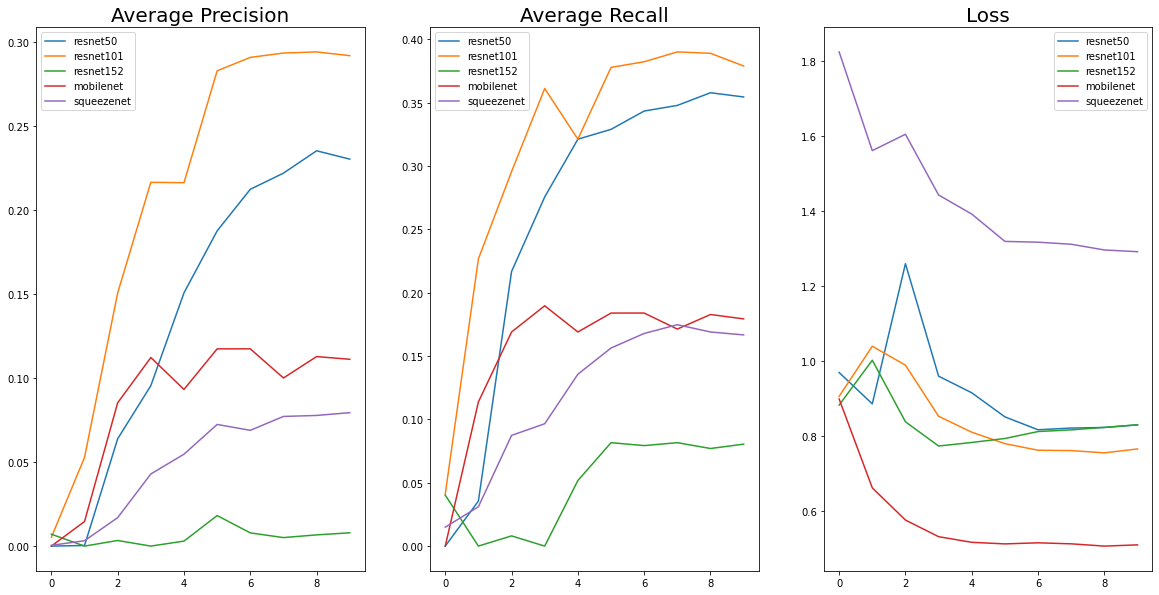

In [ ]:
plt.figure(figsize=[20, 10])
plt.subplot(1, 3, 1)
plt.title('Average Precision', fontsize=20)
for result in res1:
    label, details, model= result[:3]
    plt.plot(details['validition']['average precision'], label=label)
for result in res2:
    label, details, model= result[:3]
    plt.plot(details['validition']['average precision'], label=label)
plt.legend()

plt.subplot(1, 3, 2)
plt.title('Average Recall', fontsize=20)
for result in res1:
    label, details, model= result[:3]
    plt.plot(details['validition']['average recall'], label=label)
for result in res2:
    label, details, model= result[:3]
    plt.plot(details['validition']['average recall'], label=label)
plt.legend()

plt.subplot(1, 3, 3)
plt.title('Loss', fontsize=20)
for result in res1:
    label, details, model= result[:3]
    plt.plot(details['validition']['loss'], label=label)
for result in res2:
    label, details, model= result[:3]
    plt.plot(details['validition']['loss'], label=label)
plt.legend()
plt.show()   

From the graphs above we can see that resnet101 got the hightest percision score, it mean that this is the selected Architecture.

This net will undergo further adjustments and will be trained again, **but for now let's see the predictions and the success of the net!**




![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRKyRJy3dEJXeL1kW0fNfPYTIPH1AWL3x-YKw&usqp=CAU)

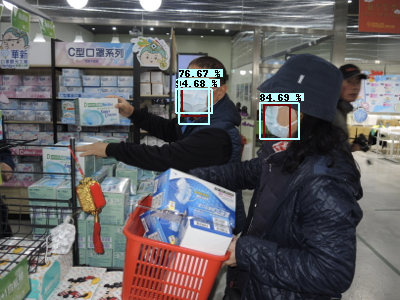

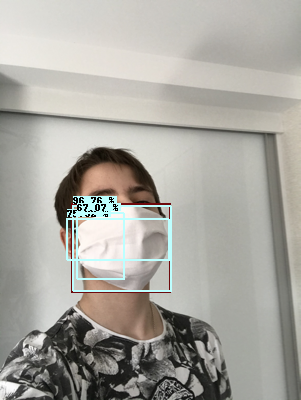

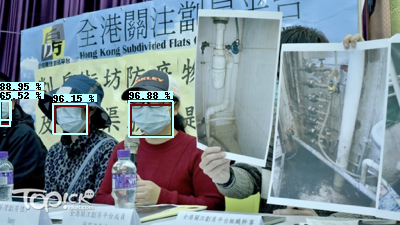

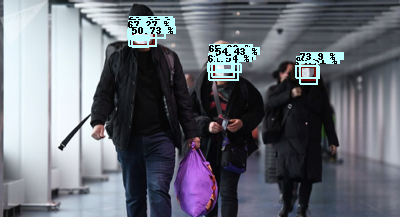

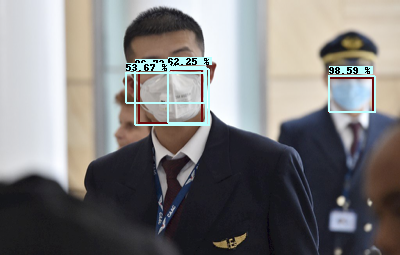

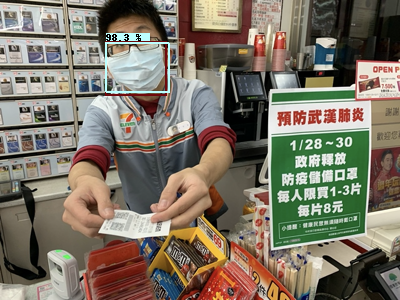

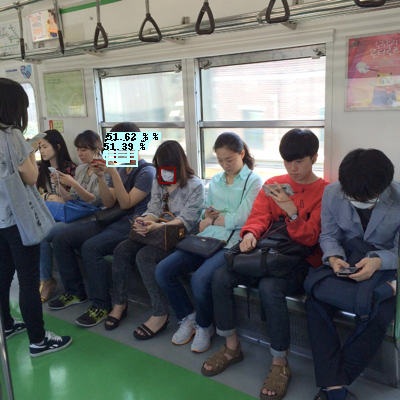

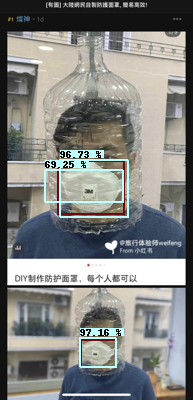

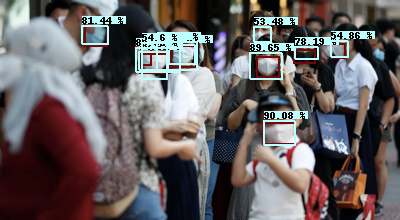

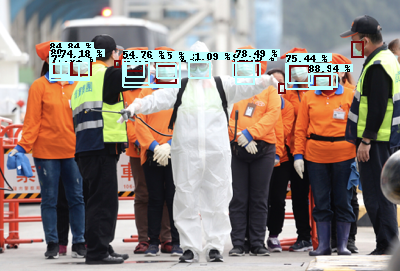

In [50]:

from PIL import Image, ImageDraw

def show_prediction(image, predictions, ground_truth=None, threshold=25):
    trans = transforms.ToPILImage()
    image = trans(image.detach().cpu())
    draw = ImageDraw.Draw(image)

    if ground_truth:
        for anno in ground_truth:
            draw.rectangle([(anno[0], anno[1]), (anno[2], anno[3])], 
                        outline ="#6e090c", width =2)
        
    for anno, score in zip(predictions[0]['boxes'], predictions[0]['scores']):
        anno = anno.detach().cpu().numpy().astype(np.int)
        score = score.detach().cpu().numpy().astype(np.float)
        
        rscore = np.round(score*100, 2)
        if rscore > threshold:
            draw.rectangle([(anno[2], anno[3]), (anno[0], anno[1])], 
                        outline ="#bdffff", width =2)
            draw.rectangle([(anno[0], anno[1]-9), 
                            (anno[0]+43, (anno[1]-2))], 
                            fill ="#bdffff")
            draw.text((anno[0], anno[1]-10), f"{rscore} %", (0,0,0))

    display(image)
def test_predictions(model, dataloader, threshold=25):

    for sample_img, sample_ann in test_data_loader:
        model.eval()
        imgs = list(img.to(device) for img in sample_img)
        annotations = []
        for dic in sample_ann:
            for bbox in dic['boxes'].detach().cpu().numpy():
                annotations.append(bbox)
        result_dict = model(imgs)
        show_prediction(imgs[0], result_dict, annotations, threshold)


def load_best_model(name):
    for m in res1:
        if m[0] == name:
            model = get_model(m[0])
            model.load_state_dict(m[2])
            model.to(device)
            return model, m[1]
dirty_model, dirty_result = load_best_model('resnet101')
test_predictions(dirty_model, test_data_loader, 50)

# AdaMod

AdaMod is a stochastic optimizer that restricts adaptive learning rates with adaptive and momental upper bounds. The dynamic learning rate bounds are based on the exponential moving averages of the adaptive learning rates themselves, which smooth out unexpected large learning rates and stabilize the training of deep neural networks.

AdaMod is a drop in replacement for Adam. The only change is a new hyperparameter called B3, or Beta3. This controls the degree of lookback for the long term clipping average.


# cosine learning decay:

A number of Schedulers were tested to accommodate some learning in training:

**StepLR** - which requires a lot of time for good adjusting the scheduler hyperparameters. 

**cosine learing decay** - implemented cosine learing decay implementation from pytorch Schedulers which gave a different learning rate (compared to the optimizer learning rate and could not be used as mention in the git) manual cosine learing decay implementation which that solve the problem and achieved a moderate reduction in learning rate throughout training and evalotion learning rate values ​​as the optimizers



*references*

* [An Adaptive and Momental Bound Method for Stochastic Learning](https://arxiv.org/pdf/1910.12249.pdf)

* [Meet AdaMod: a new deep learning optimizer with memory](https://medium.com/@lessw/meet-adamod-a-new-deep-learning-optimizer-with-memory-f01e831b80bd)

* [cosine learning rate decay](https://medium.com/@scorrea92/cosine-learning-rate-decay-e8b50aa455b)

* [learning rate schedules and adaptive learning rate methods for deep learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)

In [10]:
!pip install adamod
import adamod as adamod

In [11]:
from torch.optim.lr_scheduler import _LRScheduler
import math
# https://github.com/pytorch/pytorch/issues/17913
class LegacyCosineAnnealingLR(_LRScheduler):
    r"""Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr and
    :math:`T_{cur}` is the number of epochs since the last restart in SGDR:

    .. math::

        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +
        \cos(\frac{T_{cur}}{T_{max}}\pi))

    When last_epoch=-1, sets initial lr as lr.

    It has been proposed in
    `SGDR: Stochastic Gradient Descent with Warm Restarts`_. Note that this only
    implements the cosine annealing part of SGDR, and not the restarts.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        T_max (int): Maximum number of iterations.
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.

    .. _SGDR\: Stochastic Gradient Descent with Warm Restarts:
        https://arxiv.org/abs/1608.03983
    """

    def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        super(LegacyCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2
                for base_lr in self.base_lrs]

# 

In [35]:
CHECKPOINT_DIR_PATH = '/content/gdrive/My Drive/Colab Notebooks/resnet101v2.pt'

In [ ]:

#Set model
model = get_model('resnet101')
# move model to the right device
model.to(device)

# let's train it for 10 epochs
num_epochs = 10

#Set Optimizer
optimizer = adamod.AdaMod(model.parameters(), lr=0.0001, weight_decay=0.0001, beta3=0.999)
# and a learning rate scheduler
lr_scheduler = LegacyCosineAnnealingLR(optimizer, T_max=num_epochs)

# Learning Rate Scheduler
lr_scheduler = LegacyCosineAnnealingLR(optimizer, T_max=num_epochs)
lr_scheduler.eta_min = 1.0000000000000002e-07

compare_result = run()
# CHECKPOINT_DIR_PATH = '/content/gdrive/My Drive/Colab Notebooks/resnet101v2.pt'
torch.save([compare_result, model.state_dict()], CHECKPOINT_DIR_PATH)


Epoch: [0]  [ 0/38]  eta: 0:02:35  lr: 0.000003  loss: 1.5206 (1.5206)  loss_classifier: 0.7124 (0.7124)  loss_box_reg: 0.0002 (0.0002)  loss_objectness: 0.6938 (0.6938)  loss_rpn_box_reg: 0.1142 (0.1142)  time: 4.1004  data: 0.8296  max mem: 11267
Epoch: [0]  [10/38]  eta: 0:01:41  lr: 0.000030  loss: 1.5366 (1.5486)  loss_classifier: 0.7114 (0.7113)  loss_box_reg: 0.0072 (0.0126)  loss_objectness: 0.6940 (0.6943)  loss_rpn_box_reg: 0.1142 (0.1304)  time: 3.6114  data: 1.2905  max mem: 11360
Epoch: [0]  [20/38]  eta: 0:01:02  lr: 0.000057  loss: 1.5366 (1.5484)  loss_classifier: 0.7070 (0.7055)  loss_box_reg: 0.0073 (0.0127)  loss_objectness: 0.6944 (0.6946)  loss_rpn_box_reg: 0.1173 (0.1356)  time: 3.4519  data: 1.2091  max mem: 11809
Epoch: [0]  [30/38]  eta: 0:00:27  lr: 0.000084  loss: 1.4832 (1.5231)  loss_classifier: 0.6846 (0.6919)  loss_box_reg: 0.0097 (0.0129)  loss_objectness: 0.6944 (0.6945)  loss_rpn_box_reg: 0.1026 (0.1238)  time: 3.4137  data: 1.1221  max mem: 11809
Epoc


creating index...
index created!
Test:  [ 0/27]  eta: 0:00:07  model_time: 0.2555 (0.2555)  evaluator_time: 0.0058 (0.0058)  time: 0.2720  data: 0.0105  max mem: 11809
Test:  [26/27]  eta: 0:00:00  model_time: 0.1815 (0.1831)  evaluator_time: 0.0091 (0.0104)  time: 0.2080  data: 0.0188  max mem: 11809
Test: Total time: 0:00:05 (0.2119 s / it)
Averaged stats: model_time: 0.1815 (0.1831)  evaluator_time: 0.0091 (0.0104)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/27]  eta: 0:00:07  model_time: 0.2573 (0.2573)  evaluator_time: 0.0006 (0.0006)  time: 0.2677  data: 0.0098  max mem: 11809
Test:  [26/27]  eta: 0:00:00  model_time: 0.1844 (0.1833)  evaluator_time: 0.0006 (0.0007)  time: 0.1985  data: 0.0192  max mem: 11809
Test: Total time: 0:00:05 (0.2029 s / it)
Averaged stats: model_time: 0.1844 (0.1833)  evaluator_time: 0.0006 (0.0007)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/27]  eta: 0:00:06  model_time: 0.2260 (0.2260)  evaluator_time: 0.0078 (0.0078)  time: 0.2425  data: 0.0086  max mem: 11809
Test:  [26/27]  eta: 0:00:00  model_time: 0.1807 (0.1806)  evaluator_time: 0.0079 (0.0091)  time: 0.2049  data: 0.0187  max mem: 11809
Test: Total time: 0:00:05 (0.2078 s / it)
Averaged stats: model_time: 0.1807 (0.1806)  evaluator_time: 0.0079 (0.0091)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.260
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/27]  eta: 0:00:06  model_time: 0.2424 (0.2424)  evaluator_time: 0.0021 (0.0021)  time: 0.2540  data: 0.0094  max mem: 11809
Test:  [26/27]  eta: 0:00:00  model_time: 0.1794 (0.1817)  evaluator_time: 0.0037 (0.0071)  time: 0.2038  data: 0.0187  max mem: 11809
Test: Total time: 0:00:05 (0.2070 s / it)
Averaged stats: model_time: 0.1794 (0.1817)  evaluator_time: 0.0037 (0.0071)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.255
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/27]  eta: 0:00:07  model_time: 0.2605 (0.2605)  evaluator_time: 0.0016 (0.0016)  time: 0.2722  data: 0.0100  max mem: 11809
Test:  [26/27]  eta: 0:00:00  model_time: 0.1815 (0.1828)  evaluator_time: 0.0026 (0.0044)  time: 0.2017  data: 0.0194  max mem: 11809
Test: Total time: 0:00:05 (0.2064 s / it)
Averaged stats: model_time: 0.1815 (0.1828)  evaluator_time: 0.0026 (0.0044)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.399
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/27]  eta: 0:00:07  model_time: 0.2534 (0.2534)  evaluator_time: 0.0014 (0.0014)  time: 0.2656  data: 0.0106  max mem: 11809
Test:  [26/27]  eta: 0:00:00  model_time: 0.1798 (0.1822)  evaluator_time: 0.0022 (0.0031)  time: 0.2004  data: 0.0197  max mem: 11809
Test: Total time: 0:00:05 (0.2045 s / it)
Averaged stats: model_time: 0.1798 (0.1822)  evaluator_time: 0.0022 (0.0031)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/27]  eta: 0:00:07  model_time: 0.2619 (0.2619)  evaluator_time: 0.0012 (0.0012)  time: 0.2734  data: 0.0101  max mem: 11809
Test:  [26/27]  eta: 0:00:00  model_time: 0.1832 (0.1832)  evaluator_time: 0.0015 (0.0024)  time: 0.2006  data: 0.0199  max mem: 11809
Test: Total time: 0:00:05 (0.2051 s / it)
Averaged stats: model_time: 0.1832 (0.1832)  evaluator_time: 0.0015 (0.0024)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.557
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/27]  eta: 0:00:06  model_time: 0.2201 (0.2201)  evaluator_time: 0.0014 (0.0014)  time: 0.2319  data: 0.0103  max mem: 11809
Test:  [26/27]  eta: 0:00:00  model_time: 0.1803 (0.1808)  evaluator_time: 0.0017 (0.0024)  time: 0.1986  data: 0.0193  max mem: 11809
Test: Total time: 0:00:05 (0.2022 s / it)
Averaged stats: model_time: 0.1803 (0.1808)  evaluator_time: 0.0017 (0.0024)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.837
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.376
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/27]  eta: 0:00:06  model_time: 0.2289 (0.2289)  evaluator_time: 0.0011 (0.0011)  time: 0.2394  data: 0.0093  max mem: 11810
Test:  [26/27]  eta: 0:00:00  model_time: 0.1803 (0.1817)  evaluator_time: 0.0013 (0.0018)  time: 0.1984  data: 0.0187  max mem: 11810
Test: Total time: 0:00:05 (0.2017 s / it)
Averaged stats: model_time: 0.1803 (0.1817)  evaluator_time: 0.0013 (0.0018)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.852
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.516
 Average Recall     (AR) @[ I


creating index...
index created!
Test:  [ 0/27]  eta: 0:00:06  model_time: 0.2359 (0.2359)  evaluator_time: 0.0010 (0.0010)  time: 0.2464  data: 0.0094  max mem: 11810
Test:  [26/27]  eta: 0:00:00  model_time: 0.1793 (0.1815)  evaluator_time: 0.0012 (0.0017)  time: 0.1971  data: 0.0180  max mem: 11810
Test: Total time: 0:00:05 (0.2008 s / it)
Averaged stats: model_time: 0.1793 (0.1815)  evaluator_time: 0.0012 (0.0017)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.848
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ I

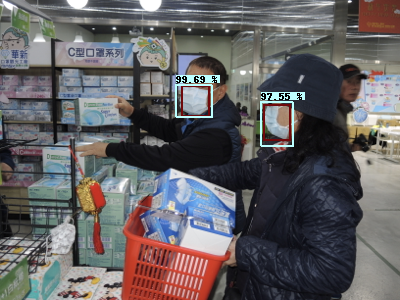

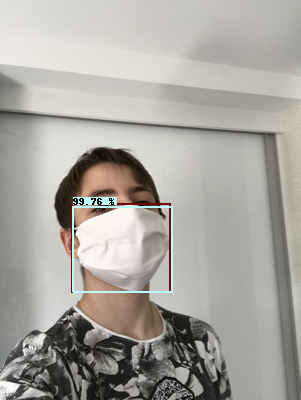

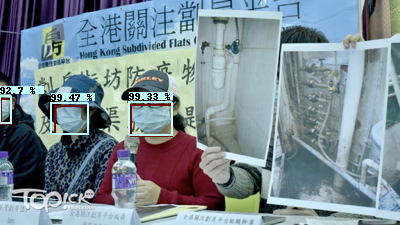

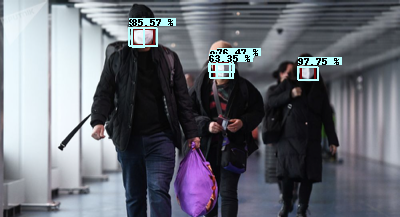

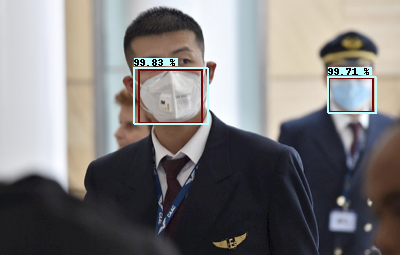

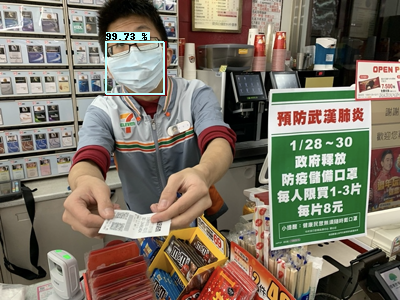

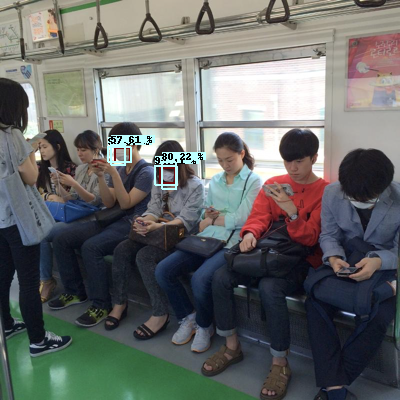

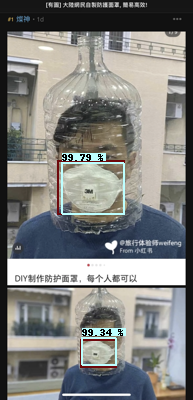

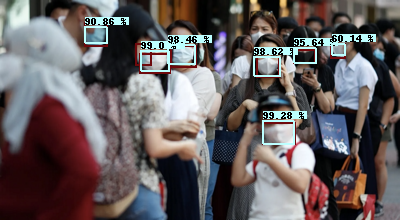

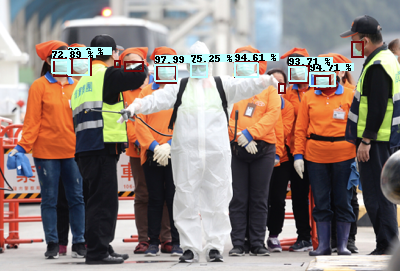

In [51]:
a = torch.load('/content/gdrive/My Drive/Colab Notebooks/resnet101v2.pt')
model = get_model('resnet101')
model.load_state_dict(a[1])
model.to(device)
test_predictions(model, test_data_loader, 55)

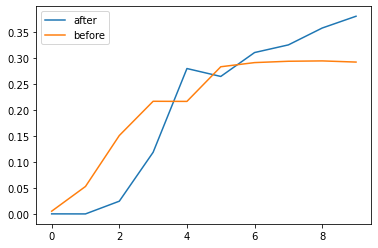

In [ ]:
plt.plot(compare_result['validition']['average precision'], label='after')
plt.plot(dirty_result['validition']['average precision'], label='before')

plt.legend()
plt.show()

[How do I check the number of parameters of a model?
](https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325)

In [11]:
import torchvision
from torchvision.models import *

models_list = [alexnet, 
               densenet121, googlenet, inception_v3, 
               mobilenet_v2, resnet101, resnet152, 
               resnet50, squeezenet1_0]

models_name = ['alexnet', 'densenet121', 'googlenet', 
               'inception_v3', 'mobilenet_v2', 'resnet101', 
               'resnet152', 'resnet50', 'squeezenet1_0']

find_max = 0
for model, name in zip(models_list, models_name):
    t = model(pretrained=True)
    pytorch_total_params = sum(p.numel() for p in t.parameters())
    print(f'{name}: {pytorch_total_params}')
    if pytorch_total_params > find_max:
        find_max =  pytorch_total_params
        max_model_name = name
print(f'Max:\n{max_model_name}: {find_max}')



alexnet: 61100840
densenet121: 7978856
googlenet: 6624904
inception_v3: 27161264
mobilenet_v2: 3504872
resnet101: 44549160
resnet152: 60192808
resnet50: 25557032
squeezenet1_0: 1248424
Max:
alexnet: 61100840


In [17]:
num_classes=2
anchor_generator = AnchorGenerator(
                        sizes=tuple([(32, 64, 128, 256) for _ in range(5)]),
                        aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)]))
backbone = torchvision.models.alexnet(pretrained=True).features
backbone.out_channels = 256
model = FasterRCNN(backbone, num_classes,
                    rpn_anchor_generator=anchor_generator,
                    rpn_head=RPNHead(backbone.out_channels, anchor_generator.num_anchors_per_location()[0]))
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes = num_classes)


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [13]:
CHECKPOINT_DIR_PATH = '/content/gdrive/My Drive/Colab Notebooks/alexnet.pt'


In [16]:
# move model to the right device
model.to(device)

# let's train it for 10 epochs
num_epochs = 10

#Set Optimizer
optimizer = adamod.AdaMod(model.parameters(), lr=0.0001, weight_decay=0.0001, beta3=0.999)
# and a learning rate scheduler
lr_scheduler = LegacyCosineAnnealingLR(optimizer, T_max=num_epochs)

# Learning Rate Scheduler
lr_scheduler = LegacyCosineAnnealingLR(optimizer, T_max=num_epochs)
lr_scheduler.eta_min = 1.0000000000000002e-07

compare_result = run()
torch.save([compare_result, model.state_dict()], CHECKPOINT_DIR_PATH)

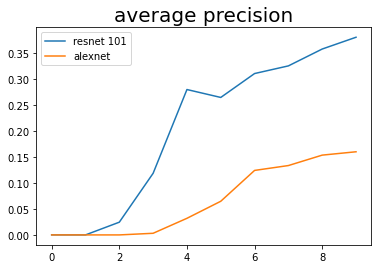

In [45]:
resnet = torch.load('/content/gdrive/My Drive/Colab Notebooks/resnet101v2.pt')
alexnet = torch.load('/content/gdrive/My Drive/Colab Notebooks/alexnet.pt')
plt.title('average precision', fontsize=20)
plt.plot(resnet[0]['validition']['average precision'], label='resnet 101')
plt.plot(alexnet['validition']['average precision'], label='alexnet')

plt.legend()
plt.show()

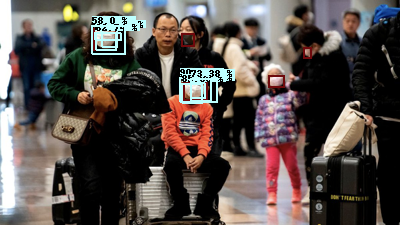

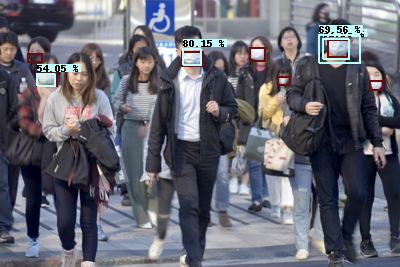

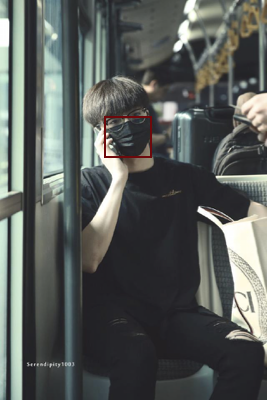

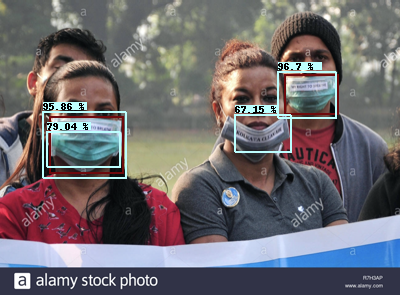

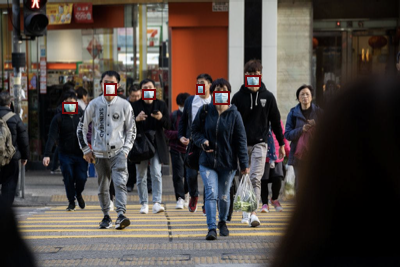

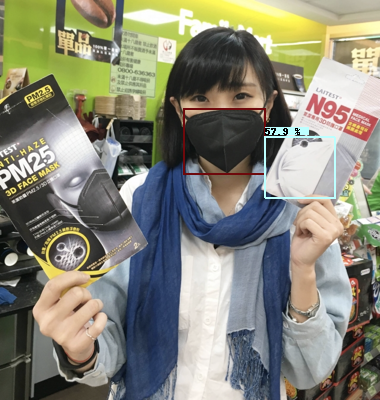

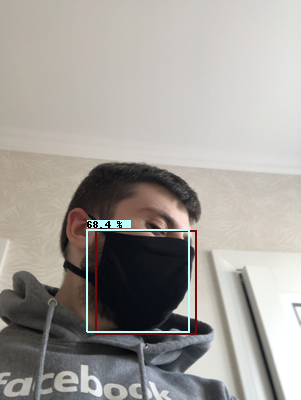

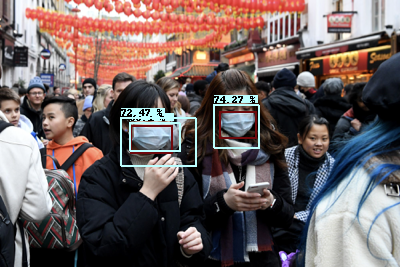

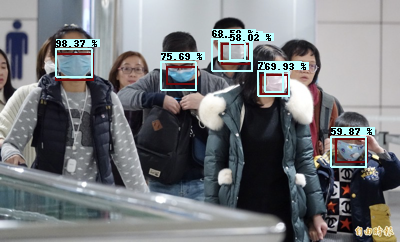

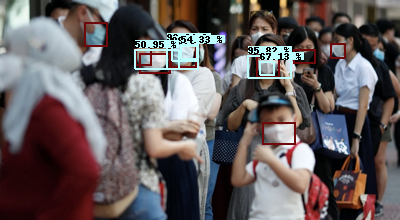

In [48]:
test_predictions(model, test_data_loader, 50)

As can be seen from the graph and forecasts choosing an architecture with a lot of features will not contribute to the improvement of the model and in fact, will hurt and lower the average accuracy. The model enters a state of overfitting. The model fails to detect masks even when they appear close and clear in the image whereas detecting wrongly other objects as face masks.
The conclusion, from the three models which were trained the largest model achieved the worst result.